# Desafio de Programação Final: Modelagem de um Sistema de Comunicação RF com Autoencoder em Pytorch


## Identificação:

**Nome:** João Pedro Moreno de Oliveira

**Matrícula:** 190128488

## Importação:

In [1]:
#allows the drive to be accessed
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import sys

!cat '/content/drive/MyDrive/Desafios de programacao - TopEng 2_2023/Desafio de programacao final/utils_exp2.py'
sys.path.append('/content/drive/MyDrive/Desafios de programacao - TopEng 2_2023/Desafio de programacao final')

# Scientific and vector computation for python
import numpy as np

# Plotting library
import matplotlib.pyplot as plt

# Optimization module in scipy
from scipy import optimize

# Machine Learning Library
import torch

# work with math and erfc
import math
from scipy.special import erfc

from pylab import *
from sklearn.manifold import TSNE

# Função Q(x)
def func_q(x):
    return (1/2)*erfc((1/math.sqrt(2))*x)

# Detector ótimo para os esquemas tradicionais de modulação
def genareteBER(M, EbNodB_range):
    # gera o vetor de BER para cada uma das modulações tradicionais: M-ASK, M-PSK e M-QAM para 
    # uma dada lista de SNRs
    m_ask = [None]*len(EbNodB_range)
    m_psk = [None]*len(EbNodB_range)
    m_qam = [None]*len(EbNodB_range)
    for n in range(0,len(EbNodB_range)):
        EbNo=10.0**(EbNodB_range[n]/10.0)
        m_ask[n] = 2*(1-(1/M))*func_q((math.sqrt((6*math.log2(M))/(M**2-1)*EbNo)))
        m_psk[n] = 2*func_q(math.sin(math.pi/M)*math.sqrt(2*math.log2(M)*EbNo))
        

In [3]:
# Scientific and vector computation for python
import numpy as np

# Plotting library
import matplotlib.pyplot as plt
%matplotlib inline

# Optimization module in scipy
from scipy import optimize

# Machine Learning Library
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# work with math and erfc
import math
from scipy.special import erfc

# aditional modules for vizualisation
from pylab import *
from sklearn.manifold import TSNE

# complementary functions
import utils_exp2

In [4]:
train_on_gpu = torch.cuda.is_available() #Check if the GPU is available
if train_on_gpu: #if yes
    device = torch.device('cuda') #Select device as GPU
    print("Treinando na GPU.")
else: #Se não
    device = torch.device('cpu') #Select device as CPU
    print("GPU indisponível, treinando na CPU.")

GPU indisponível, treinando na CPU.


##Funções Gerais

###Autoencoder


In [5]:
# Definição da Classe Autoencoder
class autoencoder(nn.Module):
    def __init__(self,n_channel, k,dim):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(M, n_net),
            nn.ReLU(True),
            nn.Linear(n_net, n_net),
            nn.BatchNorm1d(n_net, affine=True))
        self.decoder = nn.Sequential(
            nn.Linear(n_net, M),
            nn.ReLU(True),
            nn.Linear(M, M),
            nn.Softmax())

    def forward(self, x, R, n_net, EbN0):
        outs = {}
        # Número de linhas de x
        x_size = x.shape[0]

        # Encoder Layer
        x = self.encoder(x)
        # Normalização Euclidiana
        x = nn.functional.normalize(x, p=2, dim=-1)
        x = x*(math.sqrt(n_net/2))
        # Saída do vetor de codificado e normalizado
        outs['encoded'] = x

        # Channel Influence
        # Cria-se o vetor de ruído
        noise_channel = torch.normal(0.0, math.sqrt(1/(2*R*(10.0**(EbN0/10.0)))),[x_size, n_net])
        # Influencia do Canal - Soma com o ruído
        x = x + noise_channel
        # Saída do vetor de com ruído
        outs['encoded_noise'] = x

        # Decoder Layer
        x = self.decoder(x)
        # Saída do vetor de decodificado
        outs['decoded'] = x
        return outs

    def auto_encoder(self, x, n_channel):
        x = self.encoder(x)
        x = nn.functional.normalize(x, p=2, dim=-1)
        x = x*(n_channel/math.sqrt(n_channel))
        return x

    def auto_decoder(self, x):
        x = self.decoder(x)
        return x

###Treinamento

In [31]:
# Treinamento do Autoencoder
def train_autoencoder(n_channel,k, learning_rate, model,dim):
  # Função de perda do treinamento
  criterion = nn.CrossEntropyLoss()

  # Algortimo de otimização
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

  # Para guardar os valores de loss
  loss_epoch = []

  for epoch in range(num_epochs):
      # Definição do dataset (aleatório para cada época)
      dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

      # Para cada batch size em 'dataloader'
      for input_in in dataloader:
          # ===================forward=====================
          # Codificação do sinal de entrada
          output = model(input_in,R,n_net,EbN0)
          # Formatação dos dados para comparação na função de custo
          target_crossEntropy = torch.argmax(input_in, dim=-1).type(torch.LongTensor)
          # Cross-Entropy Loss
          loss = criterion(output['decoded'], target_crossEntropy)
          # ===================backward====================
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      loss_epoch.append(loss.data)
  return loss_epoch, model

### Gráfico de Loss

In [7]:
# Plot da curva de Loss
def plot_loss(n_channel, k, loss_epoch):#
  vector_loss = np.arange(0,len(loss_epoch),1)
  fig = plt.figure(figsize=(10,8))
  plt.plot(vector_loss,loss_epoch,'b',label='Autoencoder(%d,%d)'%(n_channel, k))
  plt.xlabel('Epoca')
  plt.ylabel('Loss')
  plt.title('Loss por Época')
  plt.legend(loc='lower left',ncol = 1)
  plt.grid()
  plt.show()

### Gráfico de BLER

In [8]:
# Teste do modelo treinado e cálculo da BER
def autoencoder_test(n_channel,k, model):
  for n in range(0,len(EbNodB_range)):
      EbNo=10.0**(EbNodB_range[n]/10.0)
      noise_std = np.sqrt(1/(2*R*EbNo)).item()
      noise_mean = 0.0
      no_errors = 0
      noise = torch.normal(noise_mean, noise_std,[N_teste, n_net])

      # Embaralhamneto do dataset de teste
      data = TensorDataset(test_data, torch.LongTensor(test_label))
      dataloader_test = DataLoader(data, batch_size=N_teste, shuffle=True)

      # Dividindo o dataset em labels e dados
      test_data_ = dataloader_test.dataset.tensors[0]
      label_ = np.array(dataloader_test.dataset.tensors[1])

      # Codificação do sinal
      encoded_signal = model.auto_encoder(test_data_, n_net/2)

      # Influencia do Canal
      channel_signal = encoded_signal + noise

      # Decodificação do sinal
      pred_final_signal = model.auto_decoder(channel_signal)
      parse_pred_output = pred_final_signal.tolist()
      pred_output = np.argmax(parse_pred_output,axis=1)   #retorna um array com a posição de maior argumento

      # Calculo da BER
      no_errors = (pred_output != label_)
      no_errors =  no_errors.astype(int).sum()
      ber[n] = no_errors / N_teste
      print ('SNR:',EbNodB_range[n].item(),'BLER:',ber[n], 'no_errors:',no_errors)


  # Curvas do detector ótimo
  #-- Gera as curvas téoricas para as moduações ASK, PSK e QAM para um dado M e intervalos de SNR
  ask_M, psk_M, qam_M = utils_exp2.genareteBER(2**k, EbNodB_range)

  fig = plt.figure(figsize=(10,8))
  fig_title = "Curvas de BLER para Autoencoder("+str(n_channel)+","+str(k)+")"
  plt.plot(EbNodB_range, qam_M, 'ko',label='Teorico')
  plt.plot(EbNodB_range, ber, 'bo',label='Autoencoder(%d,%d)'%(n_channel, k))
  plt.yscale('log')
  plt.xlabel('SNR Range')
  plt.ylabel('BLER')
  plt.title(fig_title)
  plt.grid()
  plt.legend(loc='lower left',ncol = 1)
  plt.show()

### Gráfico da Constelação

In [9]:
def autoencoder_result(n_channel, k, model):
  # Mensagens codigicadas pelo Encoder
  data_encoded_symbol = model.auto_encoder(torch.eye(M),n_channel)

  # Separação dos símbolos em real e imaginário
  real_symb, imag_symb = utils_exp2.split_symb(data_encoded_symbol)

  # Plotagem das constelações por uso do canal
  utils_exp2.plot_graphs_v2(real_symb.detach().numpy(),imag_symb.detach().numpy(),n_channel,sizefig=5)

## A) Modulação PSK com n = 1 e k = 2

###Parametros

In [10]:
# Parametros do modelo de Autoencoder
# Número de bits do sinal mensagem
k = 2

# Número de usos do canal
n_channel = 1

# Quantidade de mensagens possíveis
M = 2**k

# Taxa de bits por uso do canal
R = k/n_channel

# Relação sinal-ruído desejada para o treinamento
EbN0 = 7

# Para transmissão de símbolos reais basta fazer essa variável igual a 1
n_simbolos = 2

# Parametros da Rede
n_net = n_simbolos*n_channel

# Quantidade de épocas de treinamento
num_epochs = 1000* n_channel

# Tamanho do conjunto de cada treinamento - batch size
batch_size = 10*M

# Qunatidade de amostras de treinamento
N_treino = batch_size*10

# Montagem do dataset de treino
train_dataset = torch.eye(M)
data = train_dataset.repeat(int(N_treino/M),1)

# Paramêtros de Teste
N_teste = 100000*M
test_label = torch.randint(0, M, (N_teste,))
test_data = torch.nn.functional.one_hot(test_label).float()

# Variáveis de teste
EbNodB_range = torch.arange(0,8,0.5)
ber = [None]*len(EbNodB_range)


###Treinamento

In [11]:
trained_autoencoder = train_autoencoder(1, 2, 0.005, autoencoder(1,2,2),2)
epocas = trained_autoencoder[0]
trained_model = trained_autoencoder[1]
print(epocas)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[tensor(1.3860), tensor(1.3652), tensor(1.3343), tensor(1.3068), tensor(1.2696), tensor(1.2419), tensor(1.2337), tensor(1.1446), tensor(1.1232), tensor(1.1209), tensor(1.0892), tensor(1.0895), tensor(1.0747), tensor(1.0286), tensor(1.0523), tensor(1.0351), tensor(0.9439), tensor(1.0244), tensor(1.0755), tensor(0.9975), tensor(1.0157), tensor(1.0292), tensor(1.0146), tensor(1.0002), tensor(0.9547), tensor(1.0142), tensor(1.0418), tensor(1.0079), tensor(0.9626), tensor(1.0146), tensor(0.9871), tensor(0.9459), tensor(0.9692), tensor(1.0708), tensor(1.0046), tensor(0.9465), tensor(1.0013), tensor(1.0092), tensor(0.9648), tensor(1.0011), tensor(0.9795), tensor(0.9238), tensor(0.9391), tensor(0.9643), tensor(0.9827), tensor(0.9757), tensor(0.9498), tensor(0.9808), tensor(1.0366), tensor(0.9509), tensor(0.9640), tensor(0.8904), tensor(0.9569), tensor(0.9489), tensor(0.9905), tensor(0.9530), tensor(0.9286), tensor(0.9446), tensor(0.8407), tensor(0.9297), tensor(0.8410), tensor(0.8177), tensor(

### Gráfico de Loss

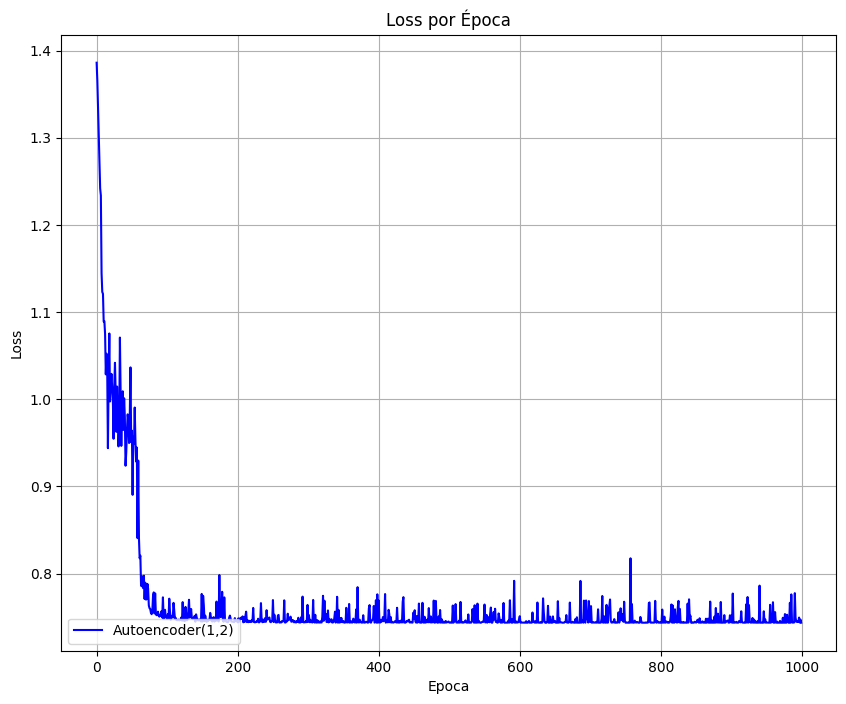

In [12]:
plot_loss(1,2,epocas)

###Gráfico de BLER

SNR: 0.0 BLER: 0.1536775 no_errors: 61471
SNR: 0.5 BLER: 0.133215 no_errors: 53286
SNR: 1.0 BLER: 0.11218 no_errors: 44872
SNR: 1.5 BLER: 0.09437 no_errors: 37748
SNR: 2.0 BLER: 0.07754 no_errors: 31016
SNR: 2.5 BLER: 0.0616425 no_errors: 24657
SNR: 3.0 BLER: 0.04754 no_errors: 19016
SNR: 3.5 BLER: 0.0367925 no_errors: 14717
SNR: 4.0 BLER: 0.0269975 no_errors: 10799
SNR: 4.5 BLER: 0.0196875 no_errors: 7875
SNR: 5.0 BLER: 0.01358 no_errors: 5432
SNR: 5.5 BLER: 0.009205 no_errors: 3682
SNR: 6.0 BLER: 0.0058325 no_errors: 2333
SNR: 6.5 BLER: 0.0037175 no_errors: 1487
SNR: 7.0 BLER: 0.0021725 no_errors: 869
SNR: 7.5 BLER: 0.00126 no_errors: 504


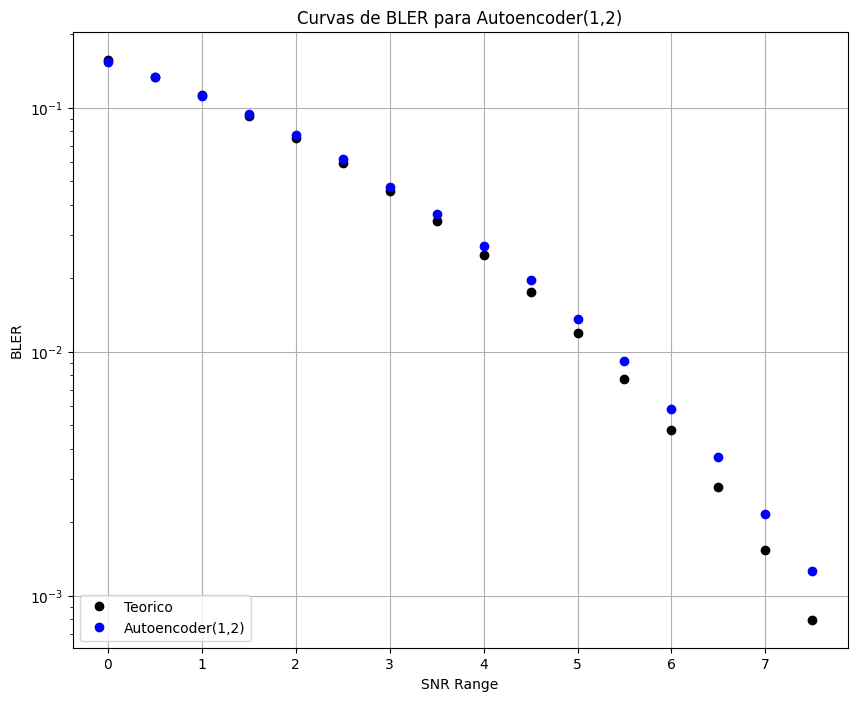

In [13]:
autoencoder_test(1,2,trained_model)

### Gráfico da Constelação

<Figure size 640x480 with 0 Axes>

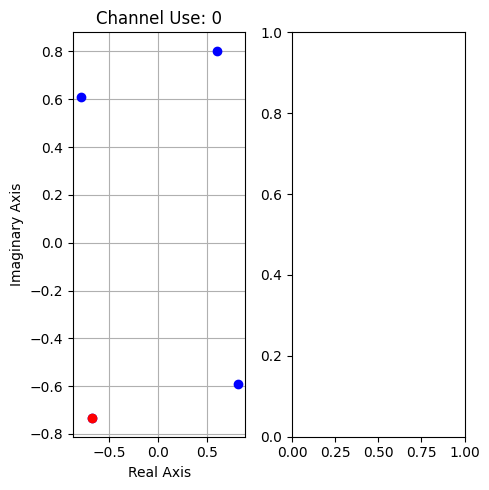

In [14]:
autoencoder_result(1,2,trained_model)

## B) Modulação PSK com n = 2 e k = 2

###Treinamento

In [15]:
trained_autoencoder = train_autoencoder(2, 2, 0.005, autoencoder(2,2,2),2)
epocas = trained_autoencoder[0]
trained_model = trained_autoencoder[1]
print(epocas)

[tensor(1.3903), tensor(1.3467), tensor(1.3379), tensor(1.3319), tensor(1.3128), tensor(1.2973), tensor(1.3223), tensor(1.2930), tensor(1.2889), tensor(1.2906), tensor(1.2948), tensor(1.2969), tensor(1.2623), tensor(1.2697), tensor(1.2436), tensor(1.2313), tensor(1.2466), tensor(1.2247), tensor(1.2243), tensor(1.2558), tensor(1.3106), tensor(1.1985), tensor(1.1877), tensor(1.1928), tensor(1.2169), tensor(1.2118), tensor(1.2086), tensor(1.1414), tensor(1.2051), tensor(1.2041), tensor(1.1766), tensor(1.1125), tensor(1.1140), tensor(1.1781), tensor(1.1251), tensor(1.1523), tensor(1.0775), tensor(1.1478), tensor(1.0358), tensor(1.0634), tensor(1.0511), tensor(1.2176), tensor(1.0999), tensor(1.0562), tensor(0.9810), tensor(0.9961), tensor(1.0261), tensor(1.0305), tensor(0.9914), tensor(1.0181), tensor(1.0770), tensor(1.2005), tensor(0.9534), tensor(0.9646), tensor(0.9565), tensor(0.9965), tensor(0.9567), tensor(1.0104), tensor(1.1291), tensor(1.0160), tensor(0.9402), tensor(0.9977), tensor(

### Gráfico de Loss

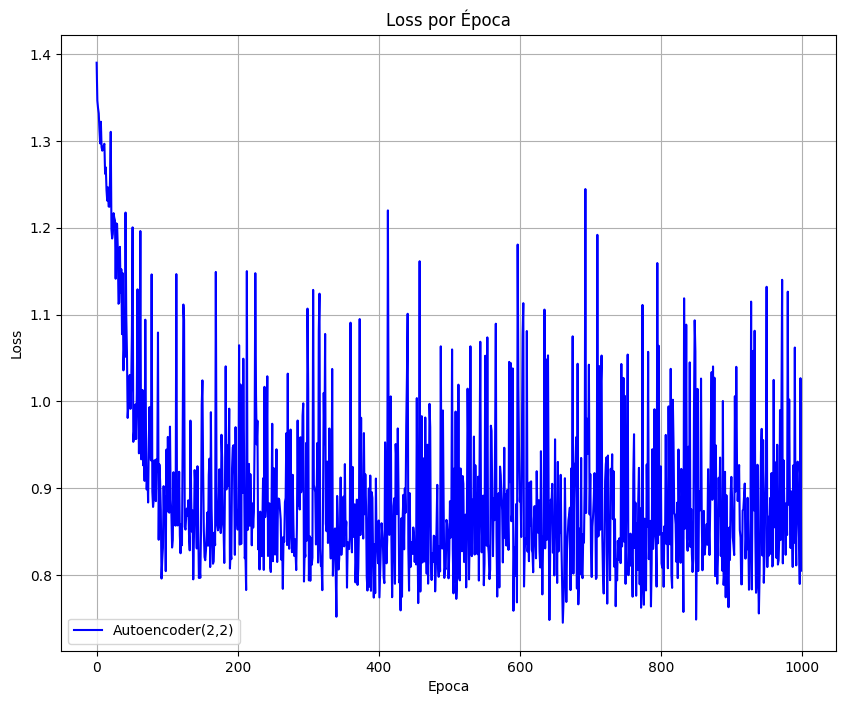

In [16]:
plot_loss(2,2,epocas)

### Gráfico de BLER

SNR: 0.0 BLER: 0.32425 no_errors: 129700
SNR: 0.5 BLER: 0.30368 no_errors: 121472
SNR: 1.0 BLER: 0.2843975 no_errors: 113759
SNR: 1.5 BLER: 0.263415 no_errors: 105366
SNR: 2.0 BLER: 0.24226 no_errors: 96904
SNR: 2.5 BLER: 0.2227625 no_errors: 89105
SNR: 3.0 BLER: 0.20284 no_errors: 81136
SNR: 3.5 BLER: 0.1838775 no_errors: 73551
SNR: 4.0 BLER: 0.1638075 no_errors: 65523
SNR: 4.5 BLER: 0.1451825 no_errors: 58073
SNR: 5.0 BLER: 0.1277175 no_errors: 51087
SNR: 5.5 BLER: 0.1098475 no_errors: 43939
SNR: 6.0 BLER: 0.09416 no_errors: 37664
SNR: 6.5 BLER: 0.0804025 no_errors: 32161
SNR: 7.0 BLER: 0.0664425 no_errors: 26577
SNR: 7.5 BLER: 0.05384 no_errors: 21536


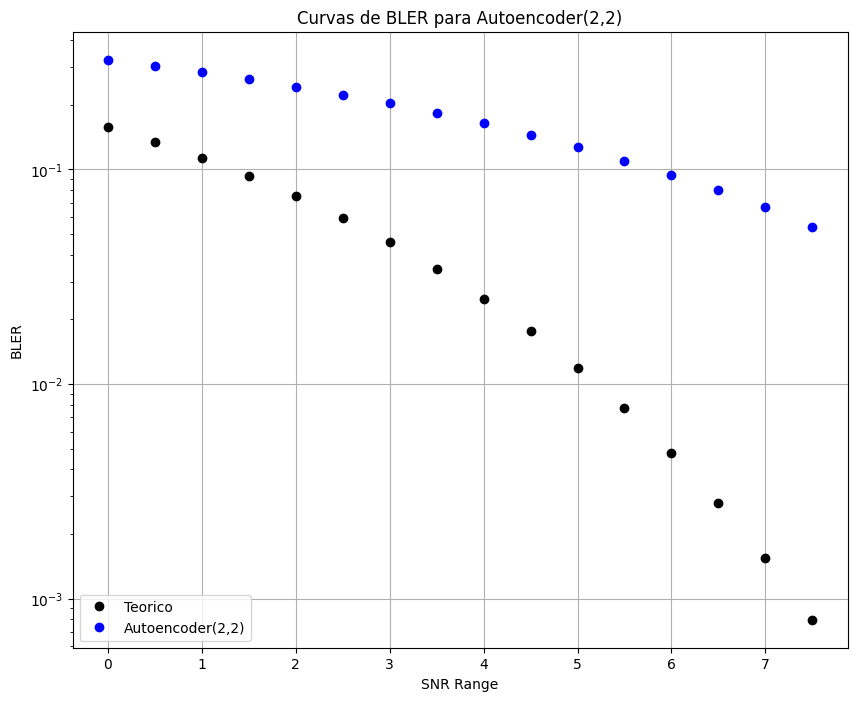

In [17]:
autoencoder_test(2,2,trained_model)

### Gráfico da Constelação

IndexError: ignored

<Figure size 640x480 with 0 Axes>

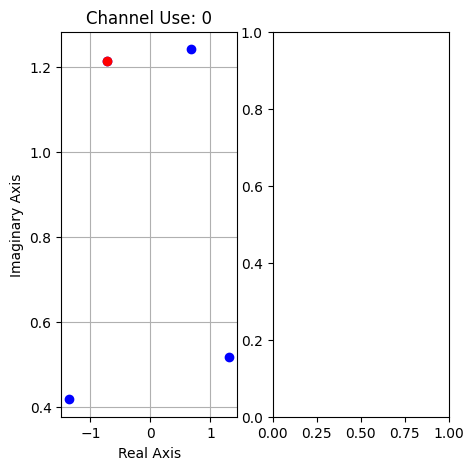

In [18]:
autoencoder_result(2,2,trained_model)

## C) Modulação QAM com n = 3 e k = 2

###Treinamento

In [19]:
trained_autoencoder = train_autoencoder(3, 2, 0.005, autoencoder(3,2,-1),-1)
epocas = trained_autoencoder[0]
trained_model = trained_autoencoder[1]
print(epocas)

[tensor(1.3544), tensor(1.3446), tensor(1.3132), tensor(1.3218), tensor(1.2802), tensor(1.2333), tensor(1.2629), tensor(1.2852), tensor(1.2472), tensor(1.2547), tensor(1.2704), tensor(1.2355), tensor(1.2593), tensor(1.2240), tensor(1.2138), tensor(1.2118), tensor(1.2237), tensor(1.2184), tensor(1.2038), tensor(1.2210), tensor(1.2186), tensor(1.2244), tensor(1.2149), tensor(1.2140), tensor(1.2129), tensor(1.1901), tensor(1.2146), tensor(1.1695), tensor(1.1641), tensor(1.1750), tensor(1.1146), tensor(1.0963), tensor(1.1057), tensor(1.0293), tensor(1.0727), tensor(1.0278), tensor(1.0905), tensor(0.9901), tensor(1.0318), tensor(1.0290), tensor(0.9821), tensor(0.9625), tensor(0.9631), tensor(0.9890), tensor(1.0175), tensor(0.9789), tensor(0.9657), tensor(1.0114), tensor(0.9881), tensor(1.0073), tensor(0.9167), tensor(0.8832), tensor(0.9245), tensor(0.9561), tensor(0.9167), tensor(0.9251), tensor(0.8810), tensor(0.8556), tensor(0.8356), tensor(0.8371), tensor(0.8228), tensor(0.8203), tensor(

### Gráfico de Loss

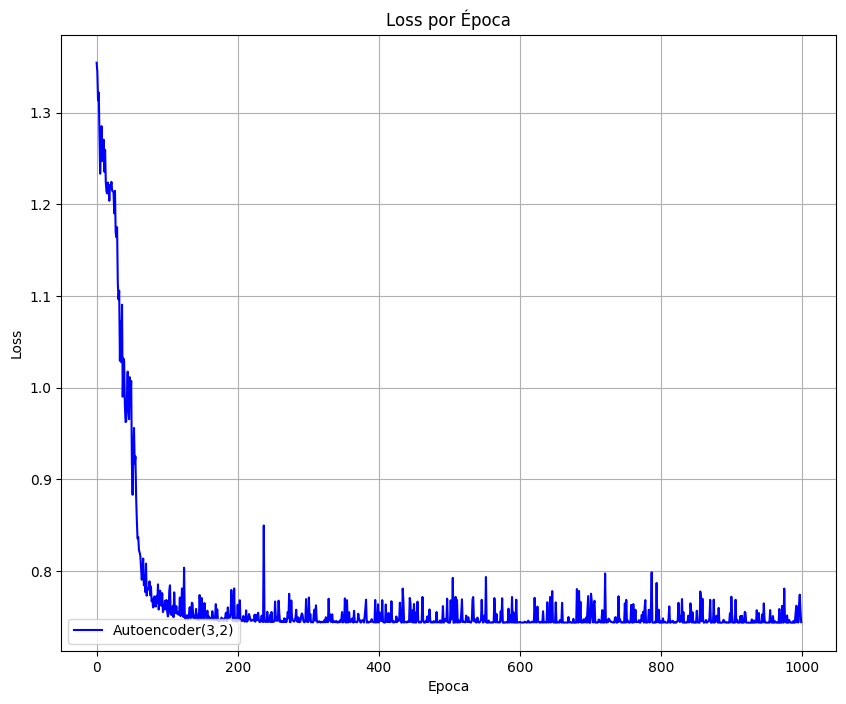

In [20]:
plot_loss(3,2,epocas)

### Gráfico de BLER

SNR: 0.0 BLER: 0.1528375 no_errors: 61135
SNR: 0.5 BLER: 0.1311975 no_errors: 52479
SNR: 1.0 BLER: 0.109525 no_errors: 43810
SNR: 1.5 BLER: 0.091575 no_errors: 36630
SNR: 2.0 BLER: 0.0743225 no_errors: 29729
SNR: 2.5 BLER: 0.059215 no_errors: 23686
SNR: 3.0 BLER: 0.0458375 no_errors: 18335
SNR: 3.5 BLER: 0.0348725 no_errors: 13949
SNR: 4.0 BLER: 0.025225 no_errors: 10090
SNR: 4.5 BLER: 0.0180825 no_errors: 7233
SNR: 5.0 BLER: 0.0121275 no_errors: 4851
SNR: 5.5 BLER: 0.0082425 no_errors: 3297
SNR: 6.0 BLER: 0.0050125 no_errors: 2005
SNR: 6.5 BLER: 0.0030775 no_errors: 1231
SNR: 7.0 BLER: 0.00161 no_errors: 644
SNR: 7.5 BLER: 0.0009 no_errors: 360


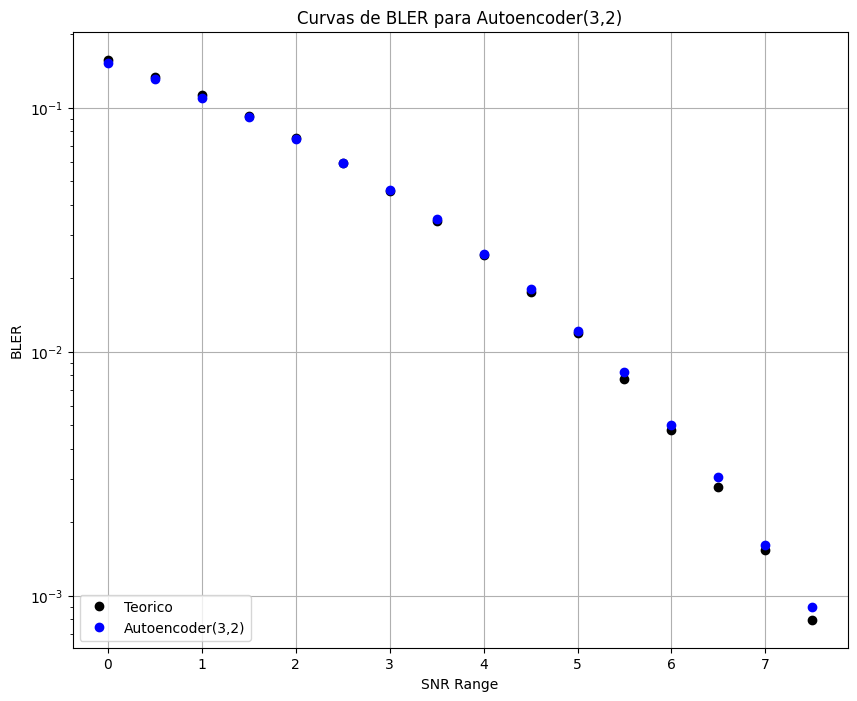

In [21]:
autoencoder_test(3,2,trained_model)

### Gráfico da Constelação

IndexError: ignored

<Figure size 640x480 with 0 Axes>

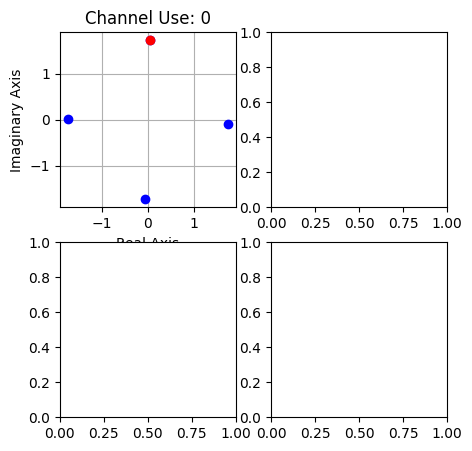

In [22]:
autoencoder_result(3,2,trained_model)

## D) Modulação PSK com n = 2 e k = 3

###Treinamento

In [23]:
trained_autoencoder = train_autoencoder(2, 3, 0.005, autoencoder(2,3,2),2)
epocas = trained_autoencoder[0]
trained_model = trained_autoencoder[1]
print(epocas)

[tensor(1.3916), tensor(1.3849), tensor(1.3783), tensor(1.3950), tensor(1.3847), tensor(1.3771), tensor(1.3865), tensor(1.3869), tensor(1.3887), tensor(1.3836), tensor(1.3883), tensor(1.3865), tensor(1.3909), tensor(1.3867), tensor(1.3845), tensor(1.3878), tensor(1.3848), tensor(1.3856), tensor(1.3837), tensor(1.3899), tensor(1.3876), tensor(1.3857), tensor(1.3867), tensor(1.3870), tensor(1.3873), tensor(1.3877), tensor(1.3870), tensor(1.3867), tensor(1.3853), tensor(1.3781), tensor(1.3590), tensor(1.3609), tensor(1.3405), tensor(1.3308), tensor(1.3226), tensor(1.3134), tensor(1.2978), tensor(1.2854), tensor(1.2737), tensor(1.2657), tensor(1.2454), tensor(1.2613), tensor(1.2054), tensor(1.1359), tensor(1.1212), tensor(1.2211), tensor(1.1598), tensor(1.2010), tensor(1.1877), tensor(1.1877), tensor(1.2447), tensor(1.1722), tensor(1.1461), tensor(1.1720), tensor(1.2153), tensor(1.2181), tensor(1.1718), tensor(1.1575), tensor(1.1580), tensor(1.1036), tensor(1.1442), tensor(1.0718), tensor(

### Gráfico de Loss

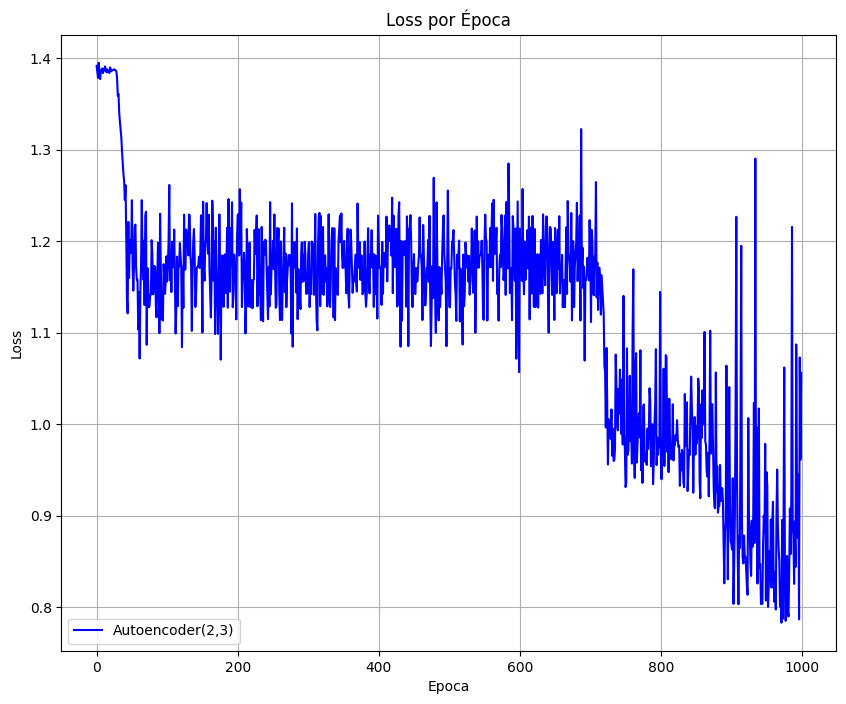

In [24]:
plot_loss(2,3,epocas)

### Gráfico de BLER

SNR: 0.0 BLER: 0.3391625 no_errors: 135665
SNR: 0.5 BLER: 0.3190125 no_errors: 127605
SNR: 1.0 BLER: 0.30056 no_errors: 120224
SNR: 1.5 BLER: 0.2808975 no_errors: 112359
SNR: 2.0 BLER: 0.261115 no_errors: 104446
SNR: 2.5 BLER: 0.2399375 no_errors: 95975
SNR: 3.0 BLER: 0.220845 no_errors: 88338
SNR: 3.5 BLER: 0.2024525 no_errors: 80981
SNR: 4.0 BLER: 0.183255 no_errors: 73302
SNR: 4.5 BLER: 0.1641075 no_errors: 65643
SNR: 5.0 BLER: 0.1469525 no_errors: 58781
SNR: 5.5 BLER: 0.1289875 no_errors: 51595
SNR: 6.0 BLER: 0.113615 no_errors: 45446
SNR: 6.5 BLER: 0.0977525 no_errors: 39101
SNR: 7.0 BLER: 0.08352 no_errors: 33408
SNR: 7.5 BLER: 0.0704 no_errors: 28160


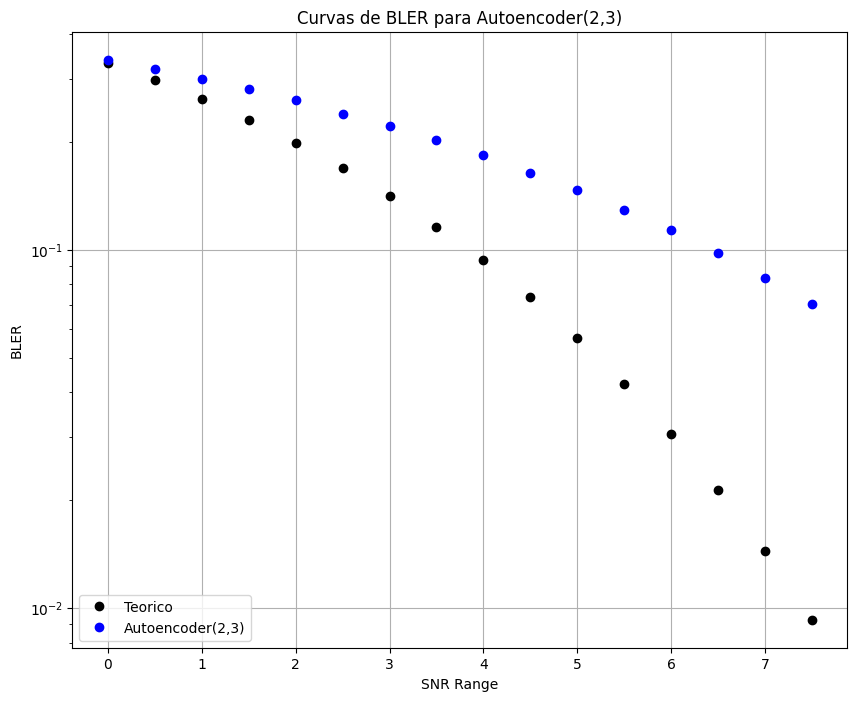

In [25]:
autoencoder_test(2,3,trained_model)

### Gráfico da Constelação

IndexError: ignored

<Figure size 640x480 with 0 Axes>

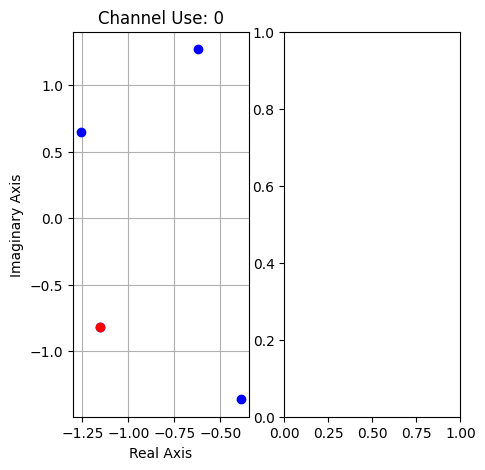

In [26]:
autoencoder_result(2,3,trained_model)

## E) Modulação QAM com n = 2 e k = 3

###Treinamento

In [27]:
trained_autoencoder = train_autoencoder(2, 3, 0.005, autoencoder(2,3,-1),-1)
epocas = trained_autoencoder[0]
trained_model = trained_autoencoder[1]
print(epocas)

[tensor(1.3460), tensor(1.3283), tensor(1.2691), tensor(1.2544), tensor(1.2675), tensor(1.2335), tensor(1.2522), tensor(1.1173), tensor(1.0789), tensor(1.0502), tensor(0.9988), tensor(1.1296), tensor(1.0236), tensor(1.0077), tensor(1.0288), tensor(1.0058), tensor(0.9374), tensor(1.0033), tensor(0.9384), tensor(0.9604), tensor(0.9201), tensor(0.8856), tensor(0.8599), tensor(0.8345), tensor(0.8807), tensor(0.8085), tensor(0.8160), tensor(0.8082), tensor(0.7949), tensor(0.7934), tensor(0.7827), tensor(0.7774), tensor(0.7894), tensor(0.7748), tensor(0.7810), tensor(0.8137), tensor(0.7769), tensor(0.8039), tensor(0.7874), tensor(0.7857), tensor(0.7670), tensor(0.7872), tensor(0.7611), tensor(0.7567), tensor(0.7638), tensor(0.7590), tensor(0.7666), tensor(0.7597), tensor(0.7586), tensor(0.7531), tensor(0.7877), tensor(0.7553), tensor(0.7531), tensor(0.7594), tensor(0.7552), tensor(0.7574), tensor(0.7630), tensor(0.7545), tensor(0.7681), tensor(0.7531), tensor(0.7523), tensor(0.7515), tensor(

### Gráfico de Loss

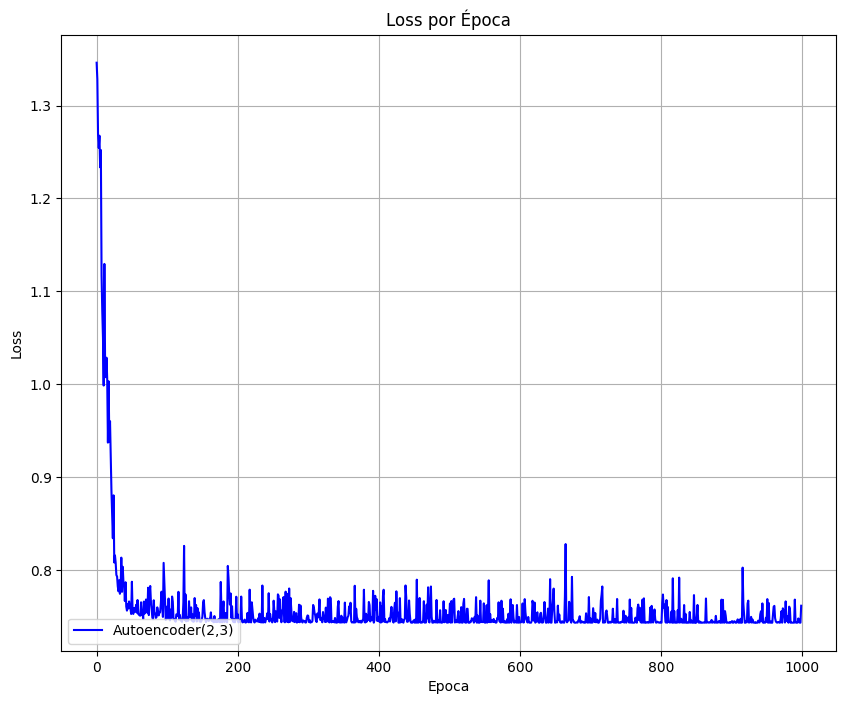

In [28]:
plot_loss(2,3,epocas)

### Gráfico de BLER

SNR: 0.0 BLER: 0.1526875 no_errors: 61075
SNR: 0.5 BLER: 0.13062 no_errors: 52248
SNR: 1.0 BLER: 0.1102925 no_errors: 44117
SNR: 1.5 BLER: 0.0912925 no_errors: 36517
SNR: 2.0 BLER: 0.0745175 no_errors: 29807
SNR: 2.5 BLER: 0.0595925 no_errors: 23837
SNR: 3.0 BLER: 0.046635 no_errors: 18654
SNR: 3.5 BLER: 0.0352925 no_errors: 14117
SNR: 4.0 BLER: 0.0256425 no_errors: 10257
SNR: 4.5 BLER: 0.0183075 no_errors: 7323
SNR: 5.0 BLER: 0.0125475 no_errors: 5019
SNR: 5.5 BLER: 0.0085225 no_errors: 3409
SNR: 6.0 BLER: 0.0051175 no_errors: 2047
SNR: 6.5 BLER: 0.003045 no_errors: 1218
SNR: 7.0 BLER: 0.00174 no_errors: 696
SNR: 7.5 BLER: 0.0008975 no_errors: 359


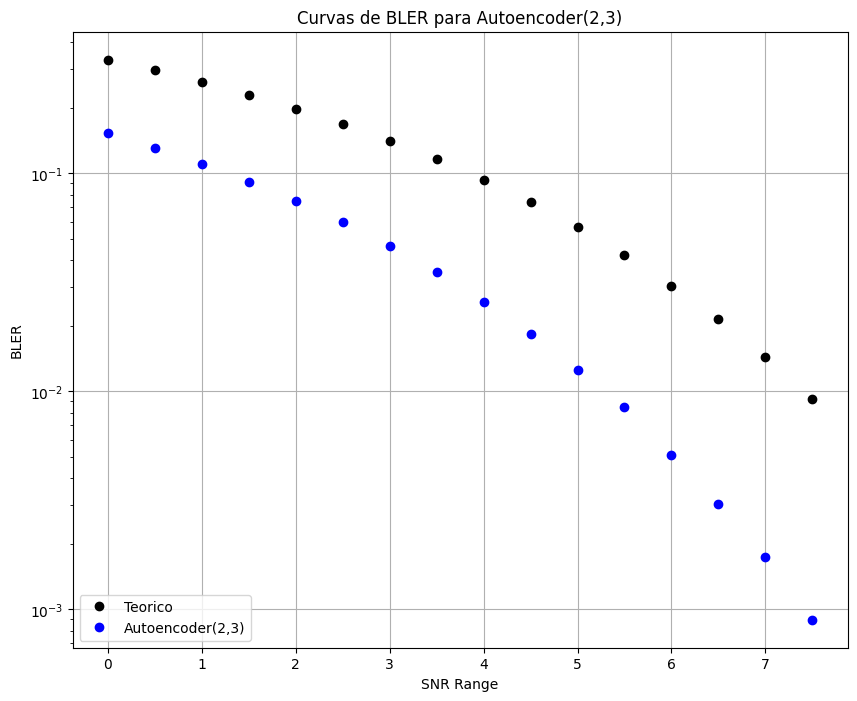

In [29]:
autoencoder_test(2,3,trained_model)

### Gráfico da Constelação

IndexError: ignored

<Figure size 640x480 with 0 Axes>

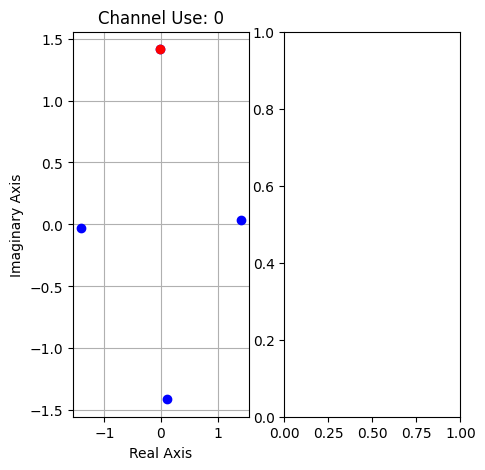

In [30]:
autoencoder_result(2,3,trained_model)